<a href="https://colab.research.google.com/github/papagorgio23/Python101/blob/master/Linear_Regression_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

We want to be able to predict output--CPlus completions in Negotiations--based on inputs, which is business days and inventory. Inventory consists of backlog (aged more than 60 days), carryover (aged under 60 days) and new (inflow of new inventory during the month).  This model will be used to set monthly production targets for CPlus Negotiations.

For this exercise we will only create one model to predict backlog completions based on backlog inputs -- business days and backlog inventory.  The full forecaster will consist of three regressions for each inventory bucket of backlog, carryover and new.

# Required Packages and Connections

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#**Pull and Explore Data**

In [ ]:
from google.colab import auth
auth.authenticate_user()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [ ]:
# First, we need to set our project. Replace the assignment below
# with your project ID.
project_id = 'ffn-dw-bigquery-prd'
!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [ ]:
!gsutil cp gs://jeff_franco/CPlus_Forecaster_Data.csv /tmp/CPlus_Forecaster_Data.csv
  
# Print the result to make sure the transfer worked.
!cat /tmp/CPlus_Forecaster_Data.csv

Copying gs://jeff_franco/CPlus_Forecaster_Data.csv...
/ [1 files][  2.3 KiB/  2.3 KiB]                                                
Operation completed over 1 objects/2.3 KiB.                                      
Year,Month,Calendar,BizDays,Backlog,BL_Completions,CarryOver,CO_Completions,New,New_Completions
2015,December,false,19,288,183,1286,434,800,67
2015,September,false,20,357,223,912,432,769,121
2015,October,false,20,262,168,980,432,757,100
2015,July,false,21,303,192,1094,462,633,100
2015,November,false,22,330,223,998,472,1046,113
2015,August,false,23,364,260,932,372,717,100
2015,November,true,19,310,179,1075,421,900,66
2015,September,true,20,358,242,953,420,762,114
2015,August,true,21,352,219,918,349,743,82
2015,October,true,21,273,185,1032,489,828,114
2015,December,true,22,324,219,1300,508,887,91
2015,July,true,23,365,247,1137,500,601,93
2016,September,false,18,246,151,1257,483,1100,117
2016,December,false,19,422,276,1826,698,1260,127
2016,February,false,20,431,280,1113,536,

In [ ]:
#load CSV into dataframe
df=pd.read_csv("/tmp/CPlus_Forecaster_Data.csv")

In [ ]:
df.head(10)  # inspect top rows

,Year,Month,Calendar,BizDays,Backlog,BL_Completions,CarryOver,CO_Completions,New,New_Completions
0,2015,December,False,19,288,183,1286,434,800,67
1,2015,September,False,20,357,223,912,432,769,121
2,2015,October,False,20,262,168,980,432,757,100
3,2015,July,False,21,303,192,1094,462,633,100
4,2015,November,False,22,330,223,998,472,1046,113
5,2015,August,False,23,364,260,932,372,717,100
6,2015,November,True,19,310,179,1075,421,900,66
7,2015,September,True,20,358,242,953,420,762,114
8,2015,August,True,21,352,219,918,349,743,82
9,2015,October,True,21,273,185,1032,489,828,114


In [ ]:
#inspect data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
Year               50 non-null int64
Month              50 non-null object
Calendar           50 non-null bool
BizDays            50 non-null int64
Backlog            50 non-null int64
BL_Completions     50 non-null int64
CarryOver          50 non-null int64
CO_Completions     50 non-null int64
New                50 non-null int64
New_Completions    50 non-null int64
dtypes: bool(1), int64(8), object(1)
memory usage: 3.6+ KB


In [ ]:
#look for NAs
df.isna().sum()

Year               0
Month              0
Calendar           0
BizDays            0
Backlog            0
BL_Completions     0
CarryOver          0
CO_Completions     0
New                0
New_Completions    0
dtype: int64

In [ ]:
df.describe() #review distribution of numeric fields

,Year,BizDays,Backlog,BL_Completions,CarryOver,CO_Completions,New,New_Completions
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,2016.04000,21.020000,445.780000,287.020000,1569.500000,670.820000,1187.860000,126.680000
std,0.72731,1.301334,176.309942,107.238337,619.353424,237.714517,472.678862,42.929197
min,2015.00000,18.000000,246.000000,151.000000,874.000000,349.000000,601.000000,66.000000
25%,2016.00000,20.000000,329.250000,219.750000,1137.500000,491.750000,808.500000,93.250000
50%,2016.00000,21.000000,368.000000,248.500000,1318.000000,593.500000,1034.500000,116.000000
75%,2017.00000,22.000000,523.750000,321.250000,1896.750000,770.000000,1436.250000,152.000000
max,2017.00000,23.000000,946.000000,573.000000,3208.000000,1294.000000,2365.000000,238.000000


# Prep Data for Regression

In [ ]:
#Convert non-numeric variables into factors or dummy variables
df['Calendar_N'] = pd.factorize(df.Calendar)[0]

#print(df)

#split data into dependent variable (y) and independent variables (x)

#Option 1, list every column you want to include in the feature set if there aren't that many:

df_x_variables = df[['Calendar_N','BizDays','Backlog']]

df_backlog_x = df_x_variables.values              # values converts it into a array

#
df_backlog_y = df['BL_Completions'].values        # values converts it into a array

print (df_backlog_x)

#print (df_backlog_y)

[[  0  19 288]
 [  0  20 357]
 [  0  20 262]
 [  0  21 303]
 [  0  22 330]
 [  0  23 364]
 [  1  19 310]
 [  1  20 358]
 [  1  21 352]
 [  1  21 273]
 [  1  22 324]
 [  1  23 365]
 [  0  18 246]
 [  0  19 422]
 [  0  20 431]
 [  0  20 347]
 [  0  20 444]
 [  0  21 357]
 [  0  21 336]
 [  0  21 359]
 [  0  21 329]
 [  0  22 277]
 [  0  23 379]
 [  0  23 317]
 [  1  20 371]
 [  1  20 396]
 [  1  20 361]
 [  1  20 268]
 [  1  20 292]
 [  1  20 467]
 [  1  20 475]
 [  1  21 373]
 [  1  21 395]
 [  1  22 364]
 [  1  22 408]
 [  1  23 316]
 [  0  19 675]
 [  0  21 523]
 [  0  22 571]
 [  0  22 620]
 [  0  22 769]
 [  0  22 946]
 [  0  23 668]
 [  1  20 625]
 [  1  20 762]
 [  1  21 579]
 [  1  22 668]
 [  1  22 809]
 [  1  23 524]
 [  1  23 934]]


In [ ]:
#Option 2, if you have lots of columns, use an index to define the subset of columns you want to include

df_backlog_x=df.iloc[:,2:5].values  # 2:5 will include columns 2 to 5, "iloc" means integer location
df_backlog_y=df.iloc[:,5].values   #will include column #5


In [ ]:
#OPTIONAL - if you want to include a categorical variable with more than 2 categories, you need a matrix of dummy variables

#convert categorical field to dummy variables then append to data

from statsmodels.tools import categorical   #to create dummy variables

df_month = df['Month'].values

dummy = categorical(df_month, drop=True)

#dummy.argmax(1)

#dummy

X_with_dummy = np.column_stack((df_backlog_x, dummy[:,1:]))  #drop reference dummy

print(X_with_dummy)

[[False 19 288 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [False 20 357 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 [False 20 262 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0]
 [False 21 303 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [False 22 330 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0]
 [False 23 364 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [True 19 310 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0]
 [True 20 358 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 [True 21 352 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [True 21 273 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0]
 [True 22 324 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [True 23 365 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [False 18 246 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 [False 19 422 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [False 20 431 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [False 20 347 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0]
 [False 20 444 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

# Method 1 - Linear Regression with Statmodels

The "traditional" method of statistical modeling, with a summary table of parameter estimates and diagnostic statistics

In [ ]:
import statsmodels.api as sm
from statsmodels.tools import categorical

In [ ]:
df_backlog_x2 = sm.add_constant(df_backlog_x, prepend=False)  #add constant to get intercept value

#print (df_backlog_x2)

model = sm.OLS(df_backlog_y, df_backlog_x2)
results = model.fit()
print(results.summary())

#print (results.summary(xname=['Calendar', 'BizDays', 'Backlog', 'Constant']))

TypeError: ignored

# Method 2 - SKLearn Machine Learning

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
#split data in x and y variables, and test/training variables

xTrain, xTest, yTrain, yTest = train_test_split(df_backlog_x, df_backlog_y, test_size = 1/4, random_state = 0)
print (xTrain.shape, yTrain.shape)
print (xTest.shape, yTest.shape)

(37, 3) (37,)
(13, 3) (13,)


In [ ]:
# fit a model
lm = linear_model.LinearRegression(fit_intercept =True)
model = lm.fit(xTrain, yTrain)
predictions = lm.predict(xTest)
predictions_train = lm.predict(xTrain)

In [ ]:
#The results

# The coefficients
print('Coefficients: \n', model.coef_)

#The intercept
print('Intercept: ', model.intercept_)

# The mean squared error
print("Mean squared error (test): %.2f"
      % mean_squared_error(yTest, predictions))

# The mean squared error
print("Mean squared error (train): %.2f"
      % mean_squared_error(yTrain, predictions_train))

# Explained variance score: 1 is perfect prediction
print('R-squared on test data: %.2f' % r2_score(yTest, predictions))
print('R-squared on train data: %.2f' % r2_score(yTrain, predictions_train))

Coefficients: 
 [-6.13636423  4.48815885  0.60334986]
Intercept:  -72.92600640590399
Mean squared error (test): 302.17
Mean squared error (train): 226.38
R-squared on test data: 0.97
R-squared on train data: 0.98


Text(0, 0.5, 'Predictions')

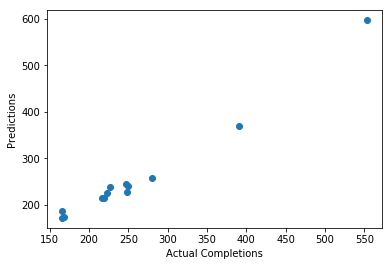

In [ ]:
# plot prediction vs actuals from test data
plt.scatter(yTest, predictions)
plt.xlabel("Actual Completions")
plt.ylabel("Predictions")

Text(0, 0.5, 'Predictions')

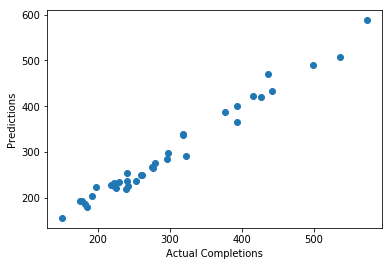

In [ ]:
# plot prediction vs actuals from test data
plt.scatter(yTrain, predictions_train)
plt.xlabel("Actual Completions")
plt.ylabel("Predictions")

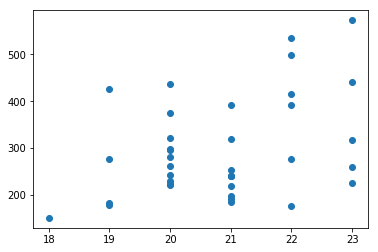

In [ ]:
plt.scatter(xTrain[:,1], yTrain)
plt.show()

# Model Training with Cross Validation

![alt text](https://cdn-images-1.medium.com/max/800/1*4G__SV580CxFj78o9yUXuQ.png)

![alt text](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)


In [ ]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, cross_validate 
from sklearn import metrics

In [ ]:
cv_results = cross_validate(model, df_backlog_x, df_backlog_y, cv=6, return_estimator=True,return_train_score=True)

for model in cv_results['estimator']:
    print(model.coef_)
    
print (cv_results['train_score'])

TypeError: ignored

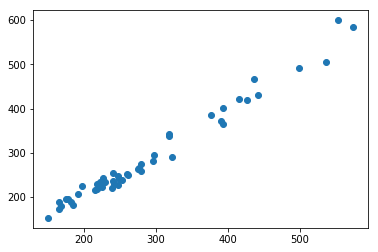

In [ ]:
# Make cross validated predictions
predictions_cv = cross_val_predict(model, df_backlog_x, df_backlog_y, cv=6)
plt.scatter(df_backlog_y, predictions_cv)

In [ ]:
accuracy = metrics.r2_score(df_backlog_y, predictions_cv)
print ("Cross-Predicted Accuracy:", accuracy)

Cross-Predicted Accuracy: 0.9765834467888527


# GBQ Connection

In [ ]:
# install pandas gbq in order to connect to GBQ
pip install pandas-gbq -U

In [ ]:
# Get credentials for GBQ connection
# You'll get a separate popup tab to log in to GBQ and get a key
# Copy and pase that key below when prompted

import pandas_gbq
import pydata_google_auth

SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=False)


In [ ]:
#write SQL query and save results to data frame
df = pandas_gbq.read_gbq( "SELECT * FROM `ffn-dw-bigquery-prd.Jeff_Franco.CPlus_Forecaster_TrainingData`", project_id='ffn-dw-bigquery-prd', credentials=credentials)

# AutoML

In [ ]:
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn
import autosklearn.regression

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,154 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Front

FileNotFoundError: ignored

In [ ]:
import autosklearn.regression
import autosklearn.metrics

In [ ]:
#xTrain, xTest, yTrain, yTest

In [ ]:

automl = autosklearn.regression.AutoSklearnRegressor()
automl.fit(xTrain, yTrain)
y_hat = automl.predict(xTest)
print("Accuracy score", autosklearn.metrics.mean_squared_error(yTest, y_hat))

In [ ]:
from sklearn.externals import joblib

joblib.dump(automl, 'vegas_automl_prediction.joblib')